(16236,)
(667, 620)


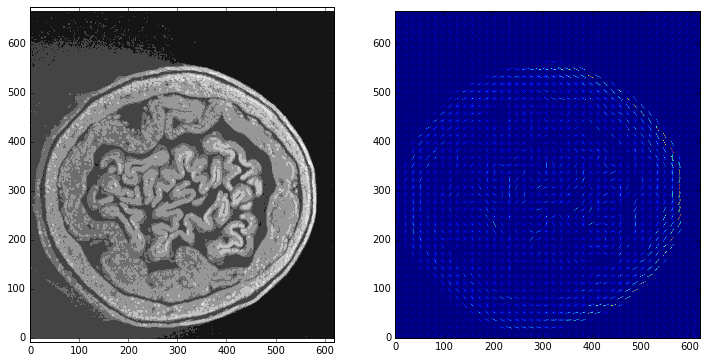

In [30]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.measure import moments
from skimage.feature import hog
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
from scipy.interpolate import interp2d

# open first image to get the image dimensions
im1 = np.array(Image.open('sargentii_17/batch3_tomo_areaij_sample17.0503.tif'),dtype=np.double)

clustered_img1 = KMeans(2).fit_predict(im1.reshape([np.prod(np.shape(im1)),1]))            
clustered_img1[clustered_img1 == clustered_img1[0]] = 2e0
clustered_img1[clustered_img1 != clustered_img1[0]] = 3e0
clustered_img1 = clustered_img1 - 2e0
clustered_img1 = clustered_img1.reshape(np.shape(im1))
clustered_img1 = np.array(clustered_img1,dtype=np.double)

m1 = moments(clustered_img1)
cr1 = m1[0, 1] / m1[0, 0]
cc1 = m1[1, 0] / m1[0, 0]


feature_vector, hog_image = hog(im1,orientations=9,pixels_per_cell=(15,15),cells_per_block=(1,1),visualise=True,normalise=True)

print np.shape(feature_vector)
print np.shape(hog_image)


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.ylim([0,np.shape(im1)[0]])
plt.xlim([0,np.shape(im1)[1]])
plt.contourf(im1,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(1, 2, 2)
plt.ylim([0,np.shape(hog_image)[0]])
plt.xlim([0,np.shape(hog_image)[1]])
plt.imshow(hog_image)
plt.savefig('imgs/hog_image.png',dpi=150)

plt.show()
